In [47]:
# sim_based_maping
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from collections import Counter
from gensim.models import Word2Vec

class sim_based_maping():
    def __init__(self,df):
        self.energy = ['기운','기력','원기','기','활력','정기'] # 에너지
        self.recovery = ['치유','처지','약','완화','진통','쉬다'] # 회복
        self.cycle = ['순환','심장','신장','소화','배출','분비'] # 순환
        self.pury = ['정화','독','해독','없애다','삭히다','그치다'] # 정화        
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        self.font = 'Malgun Gothic'  # for window
        # self.font = 'NanumGothic' # for linux
        self.df = df
        
    def processing(self,i):
        sent = self.df.iloc[i][1]
        morps = Okt().pos(sent , norm=False , stem = True)
        NV = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                NV.append(item)

        stop_words = "하다 등 되다 작용 효능  것 사용 약재 응용 주로 그 때문 경우 및 동시 각종 자주 요약 이외 모든 로서 또 동의보감 예전 이름 기록 뿐 약간 한의학 자다 때 "
        stop_words = stop_words.split(" ")

        sNV = []
        for morp in NV:
            if not morp in stop_words:
                sNV.append(morp)
        sNV = np.unique(sNV)
        return sNV

    def check_test(self,idx):
        keyword = self.df.iloc[idx][0]
        sNV = self.processing(idx)
        print(f'keyword  : {keyword }')
        print(self.df.iloc[idx][1])
        print(f'energy   : {self.energy}')
        print(f'recovery : {self.recovery}')
        print(f'cycle    : {self.cycle}')
        print(f'pury     : {self.pury}') 
        print(f'str      : {sNV}')

    def result(self,idx, top , dis):
        dims = [self.energy, self.recovery, self.cycle, self.pury]
        sNV = self.processing(idx)
        result = []
        for dim in dims:
            sub = []
            for sim_word in dim:
                for word in sNV:
                    try:
                        sub.append(self.wiki_model.wv.similarity(sim_word , word))
                    except:
                        sub.append(0)
            tmp = np.sort(sub)[::-1][:top].mean()
            result.append(tmp)

        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df['emotion'][idx]
            label = ['에너지', '회복', '순환', '정화']

            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using synonyms')
            plt.xticks(np.arange(len(label)), label)
            plt.yticks(np.arange(0,1.2,0.2))
            plt.show()
        #std = np.var(result)
        #print(f'std is {std}')
        return result

    def distibution(self,idx):
        dims = [self.energy, self.recovery, self.cycle, self.pury]
        keyword = self.df.iloc[idx][0]
        sNV = self.processing(idx)
        
        result = []
        for dim in dims:
            sub = []
            for sim_word in dim:
                for word in sNV:
                    try:
                        sub.append(self.wiki_model.wv.similarity(sim_word , word))
                    except:
                        sub.append(0)
            plt.figure() 
            plt.scatter(np.arange(len(sub)) , sub , s=1)
            plt.title(f'{keyword} and {dim}')
            plt.show()
            result.append(sub)

    def heatmap_num(self,idx, dims, figsize):
        sNV = self.processing(idx)
        item = self.df.iloc[idx][0]
        
        result = []
        for dim in dims:
            sub = []
            for word in sNV:
                try:
                    sub.append(self.wiki_model.wv.similarity(dim , word))
                except:
                    sub.append(0)
            result.append(sub)

        plt.rc('font', family=self.font)
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        plt.title(f'\'{item}\'과 문장간의 heatmap')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(sNV)),sNV)
        plt.yticks(np.arange(len(dims)),dims)
        plt.show()
        
    def heatmap(self,idx, dims, figsize):
        sNV = self.processing(idx)
        item = self.df.iloc[idx][0]
        
        result = []
        for dim in dims:
            sub = []
            for word in sNV:
                try:
                    sub.append(self.wiki_model.wv.similarity(dim , word))
                except:
                    sub.append(0)
            result.append(sub)

        plt.rc('font', family=self.font)
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        plt.title(f'\'{item}\'과 문장간의 heatmap')
        plt.pcolor(result , cmap='Reds')
        plt.xticks(np.arange(len(sNV)),sNV)
        plt.yticks(np.arange(len(dims)),dims)
        plt.colorbar()
        plt.show()
        
    def result_info(self,top):
        stat_list = []
        for i in self.df.index:
            stat_list.append(self.result(i,top,False))
        stat_list = np.array(stat_list)

        print('items var is {}'.format(np.var(stat_list,axis=0)))
        print('items mean is {}'.format(np.mean(stat_list,axis=0)))
        print('items max is {}'.format(np.max(stat_list,axis=0)))
        print('items min is {}'.format(np.min(stat_list,axis=0)))
        
    def todf(self,file_name):
        ret_df  = pd.DataFrame(columns=['감정','추정치'])
        em = []
        est = []
        cols = self.df.columns
        print(cols)
        for idx in self.df.index:
            em.append(self.df[cols[0]][idx])
            est.append(self.result(idx,3,False))
        ret_df['감정'] = em
        ret_df['추정치'] = est

        ret_df.to_csv(file_name)
        return ret_df

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


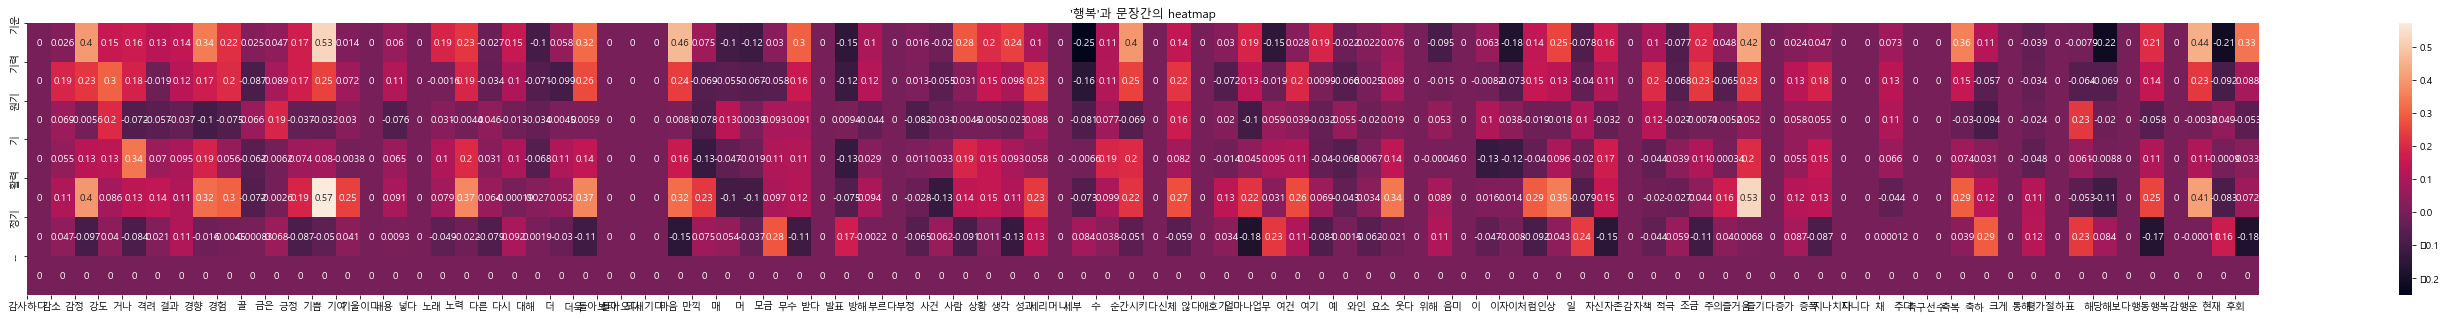

In [31]:
# sim_based_maping test
text = pd.read_csv("../data/emotion_data.csv")

data = text[['emotion','therapy']]


tmp = sim_based_maping(data)
#for i in range(0,6):
#    tmp.result(i,3,True)

idx = 0
energy = ['기운','기력','원기','기','활력','정기','--']
recovery = ['치유','처지','약','완화','진통','쉬다','--']
cycle = ['순환','심장','신장','소화','배출','분비', '--']
pury = ['정화','독','해독','없애다','삭히다','그치다']         
sum_list = energy + recovery + cycle + pury

#tmp.heatmap(idx,energy , (50,10))
tmp.heatmap_num(idx , energy, (50,5))


In [49]:
tmp = sim_based_maping(data)
test = tmp.todf("../data/emtion_estimation.csv")
test

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


Index(['emotion', 'therapy'], dtype='object')


,감정,추정치
0,행복,"[0.5415818492571512, 0.5508736968040466, 0.467..."
1,열정,"[0.5338602662086487, 0.6573270757993063, 0.558..."
2,두려움,"[0.49721041321754456, 0.7298627297083536, 0.77..."
3,분노,"[0.519708514213562, 0.623987098534902, 0.77443..."
4,우울,"[0.4931264321009318, 0.6200025081634521, 1.0, ..."
5,슬픔,"[0.4928437868754069, 0.6017196377118429, 0.607..."


In [24]:
data

,emotion,therapy
0,행복,우수한 업무성과나 탁월한 발표 등 긍정적인 사건에 대해 다른 사람들이 얼마나 깊은 ...
1,열정,어쩌면 무책임한말. 세상에는 열정으로 되는 것이 있고 되지 않는 것이 있다. 열정은...
2,두려움,우리에게 두려움을 일으키는 요인은 다양하다. 엘리베이터에 타는 것을 꺼리는 사람이 ...
3,분노,"뇌와 호르몬이 작동하는 원리에 따라 내면을 들여다보면 내 안의 분노와 열등감, 자기..."
4,우울,"슬픔, 흥미의 상실, 무관심 이 세 가지는 많은 우울증 환자들을 둘러싼 어두운 삼각..."
5,슬픔,슬픔에는 정서적 증상과 신체적 증상이 있다는 점을 알고 있는 것이 좋다. 비탄을 겪...


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


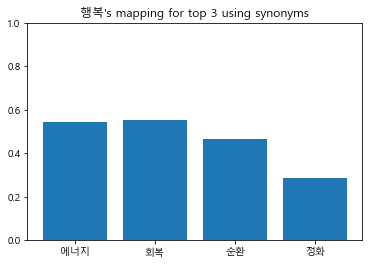

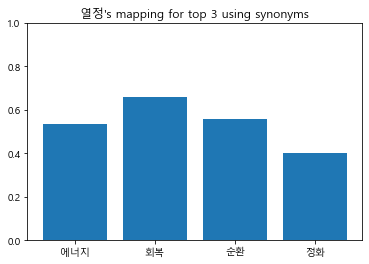

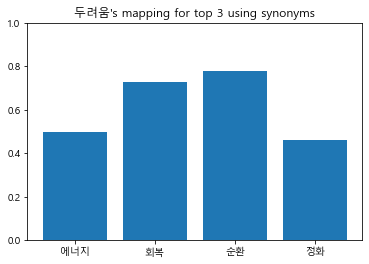

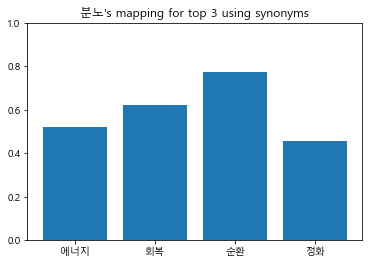

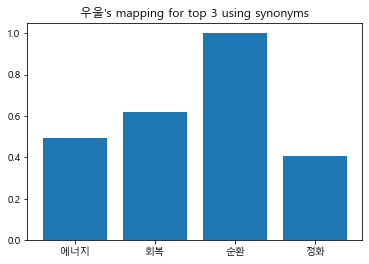

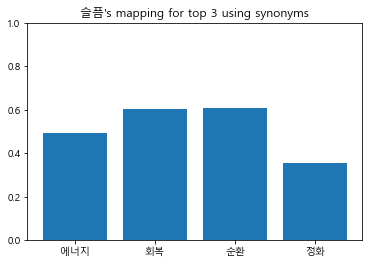

In [23]:
# 이전의 유사도를 기준으로 수치화
tmp = sim_based_maping(data)
for i in range(0,6):
    tmp.result(i,3,True)


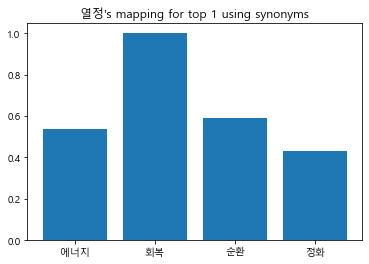

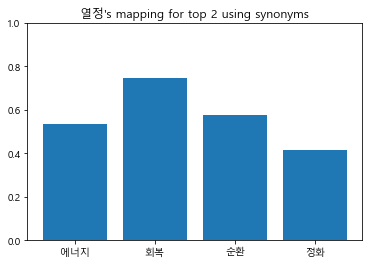

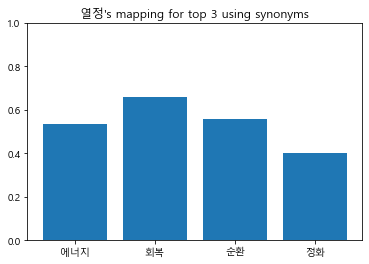

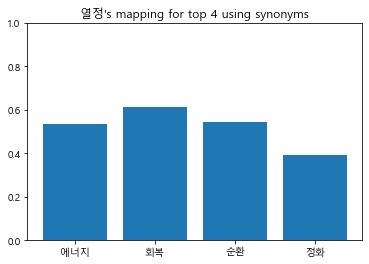

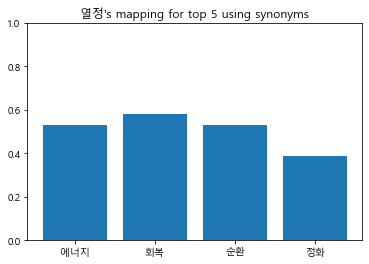

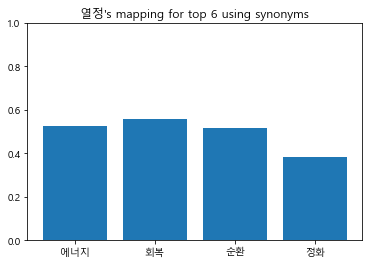

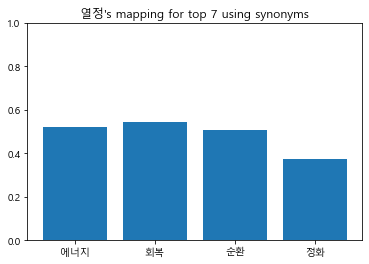

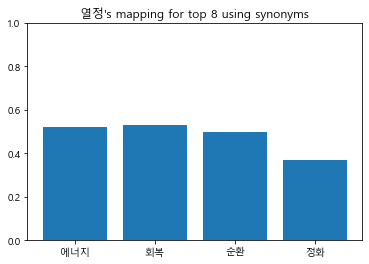

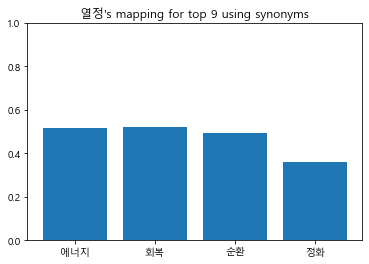

In [28]:
# 상위 몇 개를 기준으로 평균을 내는 것이 좋은가?
for topn in range(1,10):
    tmp.result(1,topn,True)